All the imports

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import save_image
import matplotlib.pyplot as plt


To get the layer numbers from which we will take the outputs of the content, style, and generated images and calculate the respective content and style losses.

In [2]:
model = models.vgg19(pretrained=True).features
print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

Creating the model class from the generated image, the original image and the style image will be passed through and this will give outputs only for the layers we're interested in which are the output layers

In [3]:
class VGG(nn.Module):
  def __init__(self):
    super(VGG, self).__init__()
    self.output_layers = [0, 5, 10, 19, 28]
    self.model = models.vgg19(pretrained=True).features[:29]

  def forward(self, x):
    features = []

    for layer_num, layer in enumerate(self.model):
      x = layer(x)

      if(layer_num in self.output_layers):
        features.append(x)

    return features

Selecting the device to use the gpu if available and preprocessing the image to have the appropriate sizes

In [4]:
device =  "cuda" if torch.cuda.is_available() else "cpu"
img_size = 512 if device=="cuda" else 256
loader = transforms.Compose(
    [transforms.Resize((img_size, img_size)),
    transforms.ToTensor()]
)

Function to load the image after preprocessing

In [5]:
def load_image(image_name):
  image = Image.open(image_name)
  image = loader(image).unsqueeze(0)
  return image.to(device)

original_img = load_image("dancing.jpg")
style_img = load_image("picasso.jpg")

generated = original_img.clone().requires_grad_(True)

Showing the original and style images

Text(0.5, 1.0, 'Style Image')

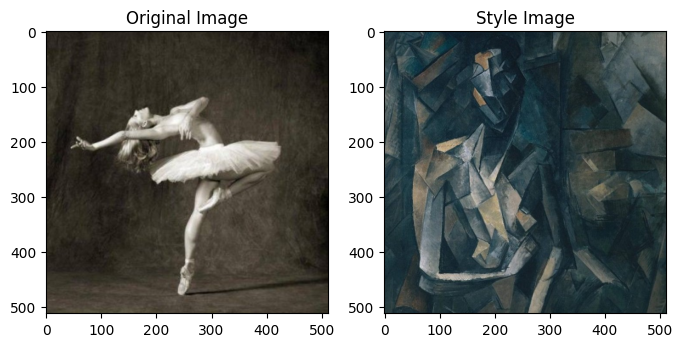

In [40]:

fig, ax = plt.subplots(1, 2, figsize=(8, 5))
ax[0].imshow(original_img[0, :, :, :].permute(1,2,0).detach().to("cpu"))
ax[0].set_title('Original Image')
ax[1].imshow(style_img[0, :, :, :].permute(1,2,0).detach().to("cpu"))
ax[1].set_title('Style Image')

Setting Up the model and the hyperparameters. In the optimizer the generated image is passed rather than the model.parameters() because the model's parameters will remain fixed and it is the pixels of the generated image that will change to get equal to the content and style images

In [ ]:
loss_list = []

In [41]:
total_steps = 6000
alpha = 1
beta = 0.1


model = VGG().to(device).eval()

learning_rate = 1e-4
optimizer = optim.Adam([generated], lr=learning_rate)

Following steps have been taken below:

*   The original image, the style image and the generated image are all passed through the model and outputs are found out are all the output layers
*   The content loss which is the distance between the generated image and the content image is calculated.
*   The style loss which is the distance between the generated image and the content image is calculated using Gram Matrices.
*   The parameters are then optimized



In [42]:
for step in range(total_steps):
  generated_features = model(generated)
  original_img_features = model(original_img)
  style_features = model(style_img)

  style_loss = 0
  original_loss = 0

  for gen_feature, orig_feature, style_feature in zip(generated_features, original_img_features, style_features):
    batch_size, channel, height, width = gen_feature.shape
    original_loss += torch.mean((gen_feature-orig_feature)**2)

    G = gen_feature.view(channel, height*width).mm(
        gen_feature.view(channel, height*width).t()
    )

    A = style_feature.view(channel, height*width).mm(
        style_feature.view(channel, height*width).t()
    )

    style_loss = torch.mean((A-G)**2)

  total_loss = alpha*original_loss + beta*style_loss
  optimizer.zero_grad()
  total_loss.backward()
  optimizer.step()

  if(step%200 == 0):
    loss_list.append(total_loss)
    print(total_loss)
    save_image(generated, "generated.png")

tensor(485360.1562, device='cuda:0', grad_fn=<AddBackward0>)
tensor(7144.3159, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3458.0869, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2417.2495, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1890.8762, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1563.0555, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1336.0636, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1171.7124, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1046.8224, device='cuda:0', grad_fn=<AddBackward0>)
tensor(946.5342, device='cuda:0', grad_fn=<AddBackward0>)
tensor(865.3586, device='cuda:0', grad_fn=<AddBackward0>)
tensor(797.4626, device='cuda:0', grad_fn=<AddBackward0>)
tensor(739.2020, device='cuda:0', grad_fn=<AddBackward0>)
tensor(688.2896, device='cuda:0', grad_fn=<AddBackward0>)
tensor(643.8956, device='cuda:0', grad_fn=<AddBackward0>)
tensor(604.6973, device='cuda:0', grad_fn=<AddBackward0>)
tensor(569.8881, device='cuda:0', grad_fn=<AddBackward0>)
ten

KeyboardInterrupt: ignored

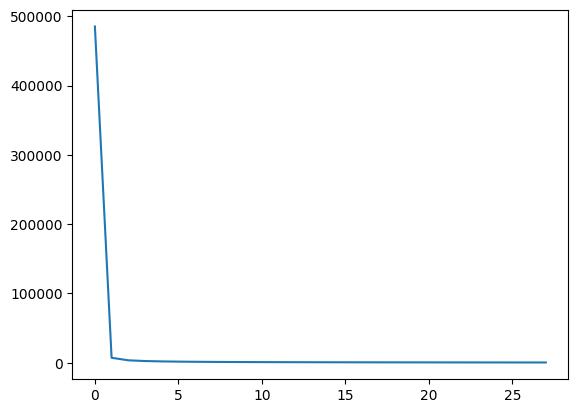

In [47]:
import matplotlib.pyplot as plt

loss_list = [float(i) for i in loss_list]
plt.plot(loss_list)

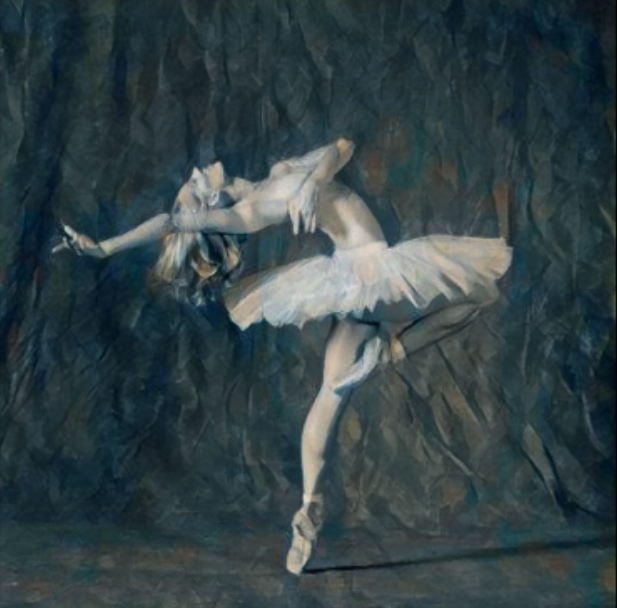

In [10]:
from PIL import Image
from IPython.display import display

image_path = "generated.png"
image = Image.open(image_path)

display(image)